# Economic Indicators

_What we learn from history is that people don't learn from history_ - Warren Buffett 

Economic data is fundamental to financial analysis, policymaking, and investment strategies. However, many economic indicators are subject to revisions, meaning initial estimates may change over time as more accurate data becomes available. Understanding these revisions is crucial for interpreting past economic conditions, refining forecasting models, and making informed decisions. We explore retrieving data from online sources such as the Federal Reserve Economic Data (FRED), its archival counterpart (ALFRED), and key derived datasets such as FRED-MD and FRED-QD. Additionally, we examine the impact of data revisions on critical economic indicators like Total Nonfarm Payrolls (PAYEMS), and methods for detecting outliers in historical data.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import textwrap
from finds.readers import Alfred, fred_md, fred_qd
from finds.utils import plot_date, plot_groupbar
from finds.recipes import is_outlier
from datetime import datetime
from pprint import pprint
from secret import credentials
VERBOSE = 0
# %matplotlib qt

## FRED

Federal Reserve Economic Data (FRED) is a widely used online database maintained by the Federal Reserve Bank of St. Louis, providing access to hundreds of thousands of economic data series from national and international sources. Users can retrieve data via the website, an Excel add-in, or API calls.  

## Retrieving data from websites

Economic data can be retrieved from the web through several methods:  

1. **Downloading structured files** – Many websites provide data in formats like CSV, Excel, or JSON, making it easy to import into analytical tools.  
2. **Web scraping** – Extracting information directly from web pages by identifying specific HTML tags or text patterns.  
3. **Using APIs** – Some platforms, including FRED, offer APIs that allow developers to automate data retrieval via structured queries. 


### Download structured files       

Many economic data providers allow users to download pre-structured files containing historical and current data. These files often include metadata, timestamps, and adjustment information.  


In [2]:
# This URL is the location of the FRED-MD csv file from the St Louis FRED
url = 'https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv'

In [3]:
# Pandas has several built-in readers for csv, xml, json, excel and even html files          
df = pd.read_csv(url, header=0)
df

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.00,6.00,6.0000,1.0000
1,1/1/1959,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9616,23.3868,22.2620,31.6664,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3917,23.7024,22.4549,31.8987,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7142,23.8459,22.5651,31.8987,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.1981,24.1903,22.8957,32.4019,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,8/1/2024,20007.209,16322.1,121.052,1.530317e+06,710038.00000,103.0135,100.9825,100.9803,102.2118,...,119.653,128.291,31.26,35.81,27.97,67.9,551667.22,933066.90,5327.6461,19.6750
789,9/1/2024,20044.142,16333.7,121.690,1.541305e+06,716388.00000,102.5969,100.3826,100.0630,101.9696,...,119.220,128.682,31.44,36.00,28.11,70.1,553347.06,934283.59,5368.5818,17.6597
790,10/1/2024,20128.752,16397.9,121.948,1.539382e+06,720393.00000,102.0854,99.5434,98.9267,101.3127,...,119.064,129.169,31.55,36.22,28.14,70.5,554377.25,937299.96,5407.3304,19.9478
791,11/1/2024,20161.687,16432.8,122.519,1.544190e+06,725925.00000,102.2549,99.8216,99.4970,101.7893,...,119.112,129.375,31.61,36.21,28.29,71.8,555000.61,938899.31,5382.4019,15.9822



### Web scraping

Web scraping involves extracting data from unstructured web pages by identifying patterns in the HTML structure. This method is useful when structured data files are unavailable, but it requires compliance with website policies.  


In [4]:
# URL that displays the most popular series in the FRED economic data web site
url = f"https://fred.stlouisfed.org/tags/series?ob=pv&pageID=1"

In [5]:
# use requests package to retrieve the web page
import requests
data = requests.get(url)
data    # a response code of 200 indicates the request has succeeded

<Response [200]>

In [6]:
# the content is just a byte-string that you can parse with Python string (or other) methods
data.content[:200]

b'<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta charset="utf-8">\n                <title>Economic Data Series by Tag | FRED | St. Louis Fed</'

In [7]:
# use the BeautifulSoup package to parse html formats
from bs4 import BeautifulSoup
soup = BeautifulSoup(data.content, 'lxml')

# based on this snippet, we want to extract the href property of the series-title class tag
print(soup.decode()[39000:40000])

s="series-title pager-series-title-gtm" href="/series/T10Y2Y" id="titleLink" style="font-size:1.2em; padding-bottom: 2px">10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity</a></h3>
</div>
<div class="display-results-popularity-bar d-none d-sm-block col-sm-2">
<span aria-label="popularity 100% popular" class="popularity-bar-span-parent" data-target="popularity-bar-span-T10Y2Y" tabindex="0" title="100% popular">
<span aria-hidden="true" class="popularity_bar" style="padding-top: 3px; padding-left:60px;"> </span> <span aria-hidden="true" class="popularity_bar_background" id="popularity-bar-span-T10Y2Y"> </span></span>
</div>
</td>
</tr>
<tr class="series-pager-attr">
<td colspan="2">
<div class="series-meta series-group-meta">
<span class="attributes">Percent, Not Seasonally Adjusted</span>
<br class="clear"/>
</div>
<div class="series-meta">
<input aria-labelledby="unitLinkT10Y2Y" class="pager-item-checkbox pager-check-series-gtm" name="sids[0]" type="checkbox" v

In [8]:
# identify all the tags whose class starts with 'series-title'
tags = soup.findAll(name='a', attrs={'class': 'series-title'})
tags[0]   # show first tag found

<a class="series-title pager-series-title-gtm" href="/series/T10Y2Y" id="titleLink" style="font-size:1.2em; padding-bottom: 2px">10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity</a>

In [9]:
# extract desired substring (which is a data series mnemonic) from the href property
details = [tag.get('href').split('/')[-1] for tag in tags]  # only want substring after last '/'
details[0]  # show first mnemonic string found

'T10Y2Y'

### Using APIs

APIs (Application Programming Interfaces) enable direct communication with data servers, allowing for real-time data retrieval. Many economic research institutions, including the St Louis Fed, offer APIs to access macroeconomic data programmatically.

In [10]:
# an API call is simply a URL string containing your parameters for the request
url = "{root}?series_id={series_id}&file_type={file_type}&api_key={api_key}".format(
    root="https://api.stlouisfed.org/fred/series", # base url of the API call
    series_id=details[0],                          # mnemonic of the data series to retrieve
    file_type='json',                              # request data be returned in json format
    api_key=credentials['fred']['api_key'])        # private api key (obtain from FRED for free)

In [11]:
# make the API call to retrieve the data
data = requests.get(url)
data.content

b'{"realtime_start":"2025-02-28","realtime_end":"2025-02-28","seriess":[{"id":"T10Y2Y","realtime_start":"2025-02-28","realtime_end":"2025-02-28","title":"10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity","observation_start":"1976-06-01","observation_end":"2025-02-28","frequency":"Daily","frequency_short":"D","units":"Percent","units_short":"%","seasonal_adjustment":"Not Seasonally Adjusted","seasonal_adjustment_short":"NSA","last_updated":"2025-02-28 16:02:07-06","popularity":100,"notes":"Starting with the update on June 21, 2019, the Treasury bond data used in calculating interest rate spreads is obtained directly from the U.S. Treasury Department (https:\\/\\/www.treasury.gov\\/resource-center\\/data-chart-center\\/interest-rates\\/Pages\\/TextView.aspx?data=yield).\\r\\nSeries is calculated as the spread between 10-Year Treasury Constant Maturity (BC_10YEAR) and 2-Year Treasury Constant Maturity (BC_2YEAR). Both underlying series are published at the U.S. T

In [12]:
# use the json package to convert byte-string data content
import json
v = json.loads(data.content)
v

{'realtime_start': '2025-02-28',
 'realtime_end': '2025-02-28',
 'seriess': [{'id': 'T10Y2Y',
   'realtime_start': '2025-02-28',
   'realtime_end': '2025-02-28',
   'title': '10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity',
   'observation_start': '1976-06-01',
   'observation_end': '2025-02-28',
   'frequency': 'Daily',
   'frequency_short': 'D',
   'units': 'Percent',
   'units_short': '%',
   'seasonal_adjustment': 'Not Seasonally Adjusted',
   'seasonal_adjustment_short': 'NSA',
   'last_updated': '2025-02-28 16:02:07-06',
   'popularity': 100,
   'notes': 'Starting with the update on June 21, 2019, the Treasury bond data used in calculating interest rate spreads is obtained directly from the U.S. Treasury Department (https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield).\r\nSeries is calculated as the spread between 10-Year Treasury Constant Maturity (BC_10YEAR) and 2-Year Treasury Constant Maturity (B

In [13]:
# Pandas can create a DataFrame directly from a dict data structure
df = DataFrame(v['seriess'])
df

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
0,T10Y2Y,2025-02-28,2025-02-28,10-Year Treasury Constant Maturity Minus 2-Yea...,1976-06-01,2025-02-28,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2025-02-28 16:02:07-06,100,"Starting with the update on June 21, 2019, the..."



### ALFRED (Archival FRED)

ALFRED extends FRED’s functionality by preserving historical versions of economic data. This allows researchers to track how data revisions impact economic narratives over time.  


In [14]:
today = int(datetime.today().strftime('%Y%m%d'))
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)

### Popular FRED series

FRED organizes its data into **categories, frequencies, and seasonal adjustments**. Some of the most frequently accessed series include employment figures, inflation metrics, and GDP growth rates. A current list of the most popular FRED series can be found [here](https://fred.stlouisfed.org/tags/series?ob=pv&pageID=1).  

In [15]:
# scrape FRED most popular page
popular = {}
titles = Alfred.popular(1)  
for title in titles:
    series = alf.request_series(title)   # requests 'series' FRED api
    if not series.empty:
        popular[title] = series.iloc[-1][['title', 'popularity']]
print(f"Most Popular Series in FRED, retrieved {today}")
DataFrame.from_dict(popular, orient='index')

Most Popular Series in FRED, retrieved 20250302


,title,popularity
T10Y2Y,10-Year Treasury Constant Maturity Minus 2-Yea...,100
MORTGAGE30US,30-Year Fixed Rate Mortgage Average in the Uni...,99
FEDFUNDS,Federal Funds Effective Rate,98
M2SL,M2,93
RRPONTSYD,Overnight Reverse Repurchase Agreements: Treas...,95
CPIAUCSL,Consumer Price Index for All Urban Consumers: ...,95
UNRATE,Unemployment Rate,95
WALCL,Assets: Total Assets: Total Assets (Less Elimi...,94
T10Y3M,10-Year Treasury Constant Maturity Minus 3-Mon...,94
GDP,Gross Domestic Product,93


Text(0.5, 0.98, 'FRED Most Popular series (retrieved 20250302)')

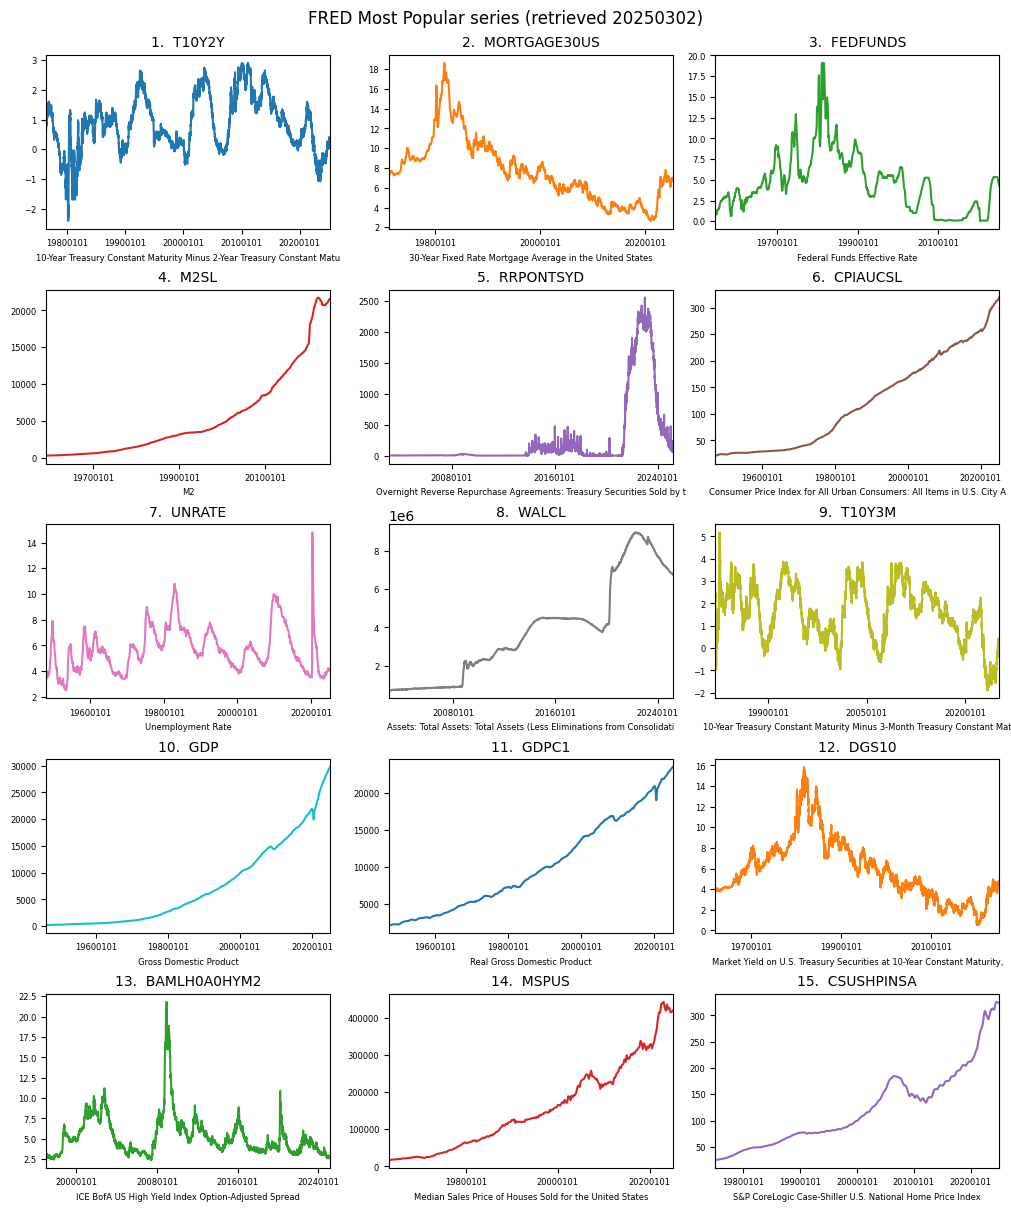

In [16]:
# plot popular series
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(10, 12), layout='constrained')
for cn, (ax, title) in enumerate(zip(np.ravel(axes), titles[:15])):
    series = alf(title)
    plot_date(series, ax=ax, title=f"{cn+1}.  {title}", xlabel=alf.header(title)[:70],
              fontsize=6, ls='-', cn=cn, nbins=4)
plt.suptitle(f"FRED Most Popular series (retrieved {today})")

### FRED series categories

One of the most closely watched FRED series is `Total Nonfarm Payroll Employment (PAYEMS)`, a key labor market indicator. This series belongs to broader employment-related categories.

In [17]:
# Retrieve grandparent,  parent and siblings of series                               
series_id, freq = 'PAYEMS', 'M'
category = alf.categories(series_id).iloc[0]
grand_category = alf.get_category(category['parent_id'])
parent_category = alf.get_category(category['id'])
category.to_frame().T


,id,name,parent_id
PAYEMS,32305,Total Nonfarm,11


In [18]:
print(f"Super category {grand_category['id']}: {grand_category['name']}")
if 'notes' in grand_category:
    print(textwrap.fill(grand_category['notes']))

Super category 11: Current Employment Statistics (Establishment Survey)
The establishment survey provides data on employment, hours, and
earnings by industry.  Numerous conceptual and methodological
differences between the current population (household) and
establishment surveys result in important distinctions in the
employment estimates derived from the surveys. Among these are:   The
household survey includes agricultural workers, the self- employed,
unpaid family workers, and private household workers among the
employed. These groups are excluded from the establishment survey.
The household survey includes people on unpaid leave among the
employed. The establishment survey does not.   The household survey is
limited to workers 16 years of age and older. The establishment survey
is not limited by age.   The household survey has no duplication of
individuals, because individuals are counted only once, even if they
hold more than one job. In the establishment survey, employees working

In [19]:
print("Parent categories:")
for child in grand_category['children']:
    node = alf.get_category(child['id'])
    if node:
        print(f" {node['id']}: {node['name']} "
              f" (children={len(node['children'])}, series={len(node['series'])})")

Parent categories:
 32305: Total Nonfarm  (children=0, series=5)
 32306: Total Private  (children=0, series=27)
 32307: Goods-Producing  (children=0, series=27)
 32326: Service-Providing  (children=0, series=1)
 32308: Private Service-Providing  (children=0, series=27)
 32309: Mining and Logging  (children=0, series=39)
 32310: Construction  (children=0, series=41)
 32311: Manufacturing  (children=0, series=31)
 32312: Durable Goods  (children=0, series=63)
 32313: Nondurable Goods  (children=0, series=55)
 32314: Trade, Transportation, and Utilities  (children=0, series=27)
 32315: Wholesale Trade  (children=0, series=33)
 32316: Retail Trade  (children=0, series=55)
 32317: Transportation and Warehousing  (children=0, series=47)
 32318: Utilities  (children=0, series=27)
 32319: Information  (children=0, series=39)
 32320: Financial Activities  (children=0, series=51)
 32321: Professional and Business Services  (children=0, series=55)
 32322: Education and Health Services  (children=

In [20]:
print("Sibling series:")
for child in parent_category['series']:
    if child['id'] == series_id:
        node = child
    print(f"  {child['id']}: {child['title']} {child['seasonal_adjustment']}"
          f" (popularity={child['popularity']})")

Sibling series:
  CES0000000010: Women Employees, Total Nonfarm Seasonally Adjusted (popularity=4)
  CES0000000039: Women Employees-To-All Employees Ratio: Total Nonfarm Seasonally Adjusted (popularity=16)
  CEU0000000010: Women Employees, Total Nonfarm Not Seasonally Adjusted (popularity=1)
  PAYEMS: All Employees, Total Nonfarm Seasonally Adjusted (popularity=83)
  PAYNSA: All Employees, Total Nonfarm Not Seasonally Adjusted (popularity=47)


In [21]:
print(f"{node['id']}: {node['title']} {node['seasonal_adjustment']}",
      f" ({node['observation_start']}-{node['observation_end']})")
print()
print(textwrap.fill(node['notes']))

PAYEMS: All Employees, Total Nonfarm Seasonally Adjusted  (1939-01-01-2025-01-01)

All Employees: Total Nonfarm, commonly known as Total Nonfarm Payroll,
is a measure of the number of U.S. workers in the economy that
excludes proprietors, private household employees, unpaid volunteers,
farm employees, and the unincorporated self-employed. This measure
accounts for approximately 80 percent of the workers who contribute to
Gross Domestic Product (GDP).  This measure provides useful insights
into the current economic situation because it can represent the
number of jobs added or lost in an economy. Increases in employment
might indicate that businesses are hiring which might also suggest
that businesses are growing. Additionally, those who are newly
employed have increased their personal incomes, which means (all else
constant) their disposable incomes have also increased, thus fostering
further economic expansion.  Generally, the U.S. labor force and
levels of employment and unemployment

## Revisions and vintage dates

Economic data revisions occur as new information becomes available, improving the accuracy of initial estimates. The Bureau of Labor Statistics (BLS), for instance, releases an initial estimate of Total Nonfarm Payroll Employment (PAYEMS) on the first Friday of each month. However, this figure is a very rough estimate, which is then revised in subsequent months as more firm-level data is collected.  

These revisions can be significant, sometimes altering economic assessments. ALFRED, the archival FRED tool, allows users to compare initial estimates with later revisions.  For the monthly values of PAYEMS in 2023, we examine the total amount of changes at each subsequent revision.


In [22]:
start, end = 20230101, 20231231
data = {}
print(f"{alf.header(series_id)} (retrieved {today}):")
latest = alf(series_id, start=start, end=end, freq=freq, realtime=True)
latest

All Employees, Total Nonfarm (retrieved 20250302):


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,154780,20250207,99991231
20230228,155086,20250207,99991231
20230331,155171,20250207,99991231
20230430,155387,20250207,99991231
20230531,155614,20250207,99991231
20230630,155871,20250207,99991231
20230731,156019,20250207,99991231
20230831,156176,20250207,99991231
20230930,156334,20250207,99991231


In [23]:
print("First Release:")
data[0] = alf(series_id, release=1, start=start, end=end, freq=freq, realtime=True)
data[0]

First Release:


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,155073,20230203,20230309
20230228,155350,20230310,20230406
20230331,155569,20230407,20230504
20230430,155673,20230505,20230601
20230531,156105,20230602,20230706
20230630,156204,20230707,20230803
20230731,156342,20230804,20230831
20230831,156419,20230901,20231005
20230930,156874,20231006,20231102


In [24]:
print("Second Release:")
data[1] = alf(series_id, release=2, start=start, end=end, freq=freq, realtime=True)
data[1]

Second Release:


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,155039,20230310,20230406
20230228,155333,20230407,20230504
20230331,155420,20230505,20230601
20230430,155766,20230602,20230706
20230531,155995,20230707,20230803
20230630,156155,20230804,20230831
20230731,156232,20230901,20231005
20230831,156538,20231006,20231102
20230930,156773,20231103,20231207


In [25]:
print("Third Release:")
data[2] = alf(series_id, release=3, start=start, end=end, freq=freq, realtime=True)
data[2]

Third Release:


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,155007,20230407,20240201
20230228,155255,20230505,20240201
20230331,155472,20230602,20240201
20230430,155689,20230707,20240201
20230531,155970,20230804,20240201
20230630,156075,20230901,20240201
20230731,156311,20231006,20240201
20230831,156476,20231103,20240201
20230930,156738,20231208,20240201


In [26]:
print("Fourth Release:")
data[3] = alf(series_id, release=4, start=start, end=end, freq=freq, realtime=True)
data[3]

Fourth Release:


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,154773,20240202,20250206
20230228,155060,20240202,20250206
20230331,155206,20240202,20250206
20230430,155484,20240202,20250206
20230531,155787,20240202,20250206
20230630,156027,20240202,20250206
20230731,156211,20240202,20250206
20230831,156421,20240202,20250206
20230930,156667,20240202,20250206


In [27]:
df = pd.concat([(data[i][series_id] - data[i-1][series_id]).rename(f"Revision {i}")
                for i in range(1, len(data))], axis=1)
labels = pd.concat([data[i]['realtime_start'].rename(f"Revision {i}")
                    for i in range(1, len(data))], axis=1).fillna(0).astype(int)
DataFrame(df.sum(axis=0).rename("Total revisions ('000)"))

,Total revisions ('000)
Revision 1,-349
Revision 2,-348
Revision 3,-2095


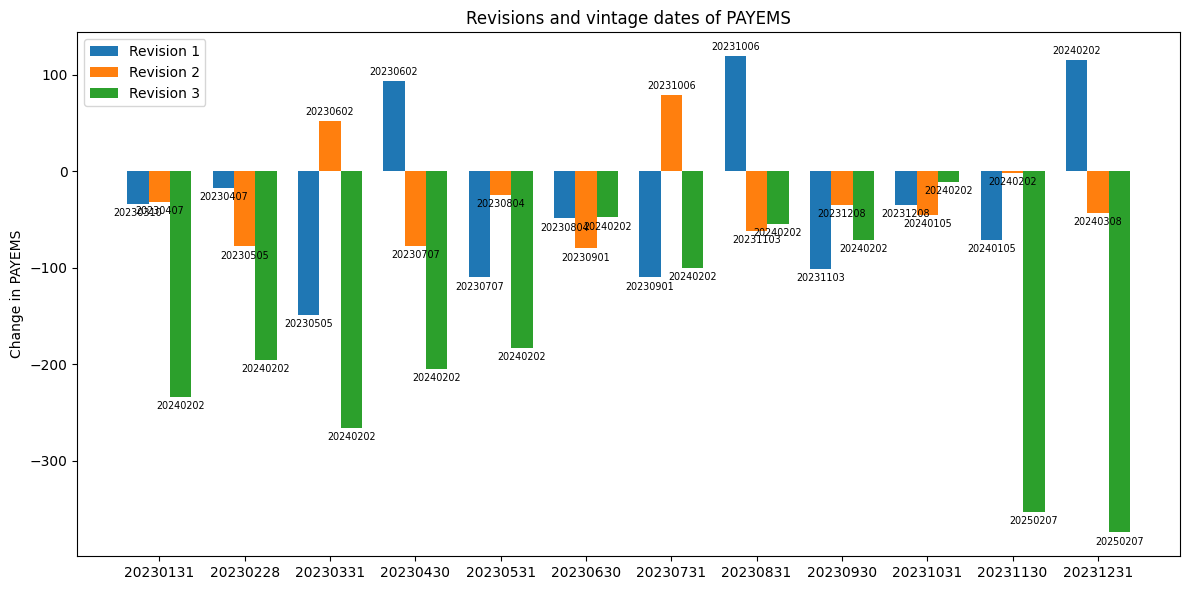

In [28]:
#df = pd.concat([data[i][series_id].rename(f"Revision {i}")
#                for i in range(1, len(data))], axis=1)
#labels = pd.concat([data[i]['realtime_start'].rename(f"Revision {i}")
#                    for i in range(1, len(data))], axis=1).fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(12, 6))
plot_groupbar(df, labels=labels, ax=ax)
plt.legend()
plt.ylabel(f'Change in {series_id}')
plt.title(f'Revisions and vintage dates of {series_id}')
plt.tight_layout()
plt.show()

### FRED-MD and FRED-QD

FRED-MD (Monthly Database) and FRED-QD (Quarterly Database) are curated datasets that streamline access to macroeconomic indicators. These datasets mimic the coverage of macroeconomic datasets used in the research literature and are updated in real-time, relieving users from the task of incorporating data changes and revisions. Historical monthly snap-shots of the datasets are also available.

### Release dates

The timing of data releases is crucial for market participants and policymakers.

In [29]:
md_df, md_transform = fred_md()
end = md_df.index[-1]
out = {}
for i, title in enumerate(md_df.columns):
    out[title] = alf(series_id=title,
                     release=1,
                     start=end, # within 4 days of monthend
                     end=end,
                     realtime=True)
    if title.startswith('S&P'):  # stock market data available same day close
        out[title] = Series({end: end}, name='realtime_start').to_frame()
    elif title in alf.splice_:   # these series were renamed or spliced
        if isinstance(Alfred.splice_[title], str):  # if renamed
            out[title] = alf(series_id=Alfred.splice_[title],
                             release=1,
                             start=end-4,  # within 4 days of monthend
                             end=end,
                             realtime=True)
        else:  # if FRED-MD series was spliced
            out[title] = pd.concat([alf(series_id=sub,
                                        reglease=1,
                                        start=end-4,  # within 4 days of monthend
                                        end=end,
                                        realtime=True)
                                    for sub in Alfred.splice_[title][1:]])

FRED-MD vintage: monthly/current.csv


In [30]:
# date convention of Consumer Sentiment
df = alf('UMCSENT', release=1, realtime=True)
out['UMCSENT'] = df[df['realtime_start'] > end - 4].iloc[:1]

In [31]:
# weekly averages of Claims
df = alf('ICNSA', release=1, realtime=True)
out['CLAIMS'] = df[df['realtime_start'] > end - 4].iloc[:1]

In [32]:
# Plot release dates of series in FRED-MD
release = Series({k: str(min(v['realtime_start'])) if v is not None and len(v)
                  else None  for k,v in out.items()}).sort_values()

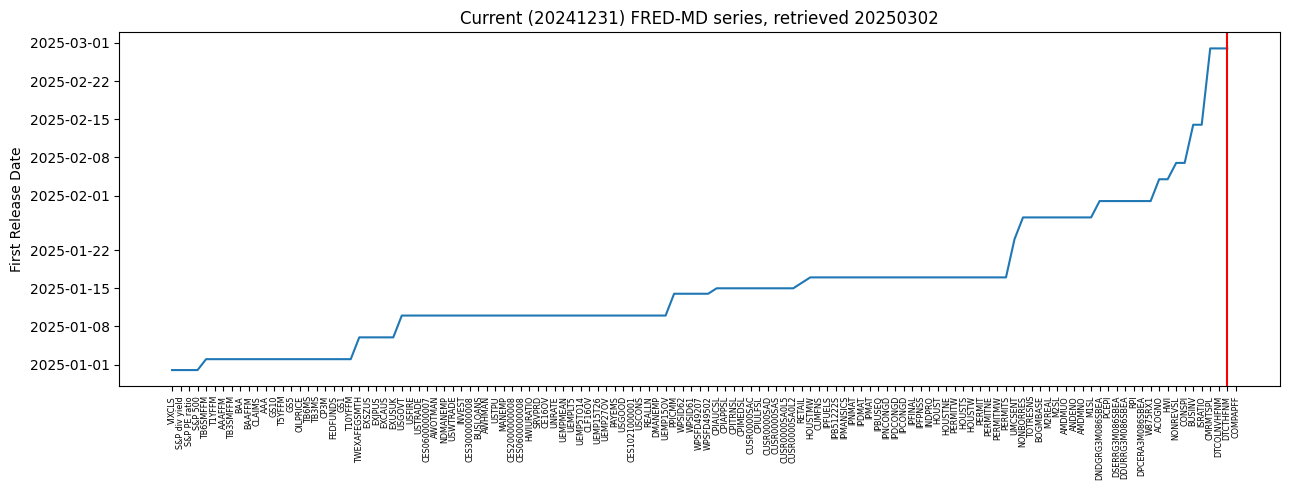

In [33]:
fig, ax = plt.subplots(clear=True, num=1, figsize=(13, 5))
ax.plot(pd.to_datetime(release, errors='coerce'))
ax.axvline(release[~release.isnull()].index[-1], c='r')
ax.set_title(f"Current ({end}) FRED-MD series, retrieved {today}")
ax.set_ylabel('First Release Date')
ax.set_xticks(np.arange(len(release)))
ax.set_xticklabels(release.index, rotation=90, fontsize='xx-small')
plt.tight_layout()

In [34]:
# Check if recently released data available to update latest FRED-MD                         
md_missing = md_df.iloc[-1]
md_missing = md_missing[md_missing.isnull()]
print("Recent values available to update missing in current FRED-MD")
for series_id in md_missing.index:
    print(alf.splice(series_id).iloc[-3:])


Recent values available to update missing in current FRED-MD
date
20241031    1538666.0
20241130    1544822.0
20241231    1555153.0
Name: CMRMTSPL, dtype: float64
date
20241031    7839
20241130    8156
20241231    7600
Name: HWI, dtype: int64
date
20241130    1.145345
20241231    1.103689
20250131         NaN
Name: HWIURATIO, dtype: float64
date
20241031    248120.0
20241130    248160.0
20241231    248851.0
Name: ACOGNO, dtype: float64
date
20241031    2585582.0
20241130    2588757.0
20241231    2584314.0
Name: BUSINV, dtype: float64
date
20241031    1.37
20241130    1.37
20241231    1.35
Name: ISRATIO, dtype: float64
date
20241031    3736897.53
20241130    3745366.76
20241231    3763355.59
Name: NONREVSL, dtype: float64
date
20241130    149.697308
20241231    149.793644
20250131           NaN
Name: CONSPI, dtype: float64
date
20241231    37.90
20250131    37.66
20250228    37.53
Name: S&P PE ratio, dtype: float64
date
20241031    554951.25
20241130    556075.09
20241231    558854.68
N

In [36]:
# Find any missing series observations, if any, now available to update current FRED-MD
Series(release.values, index=[(s, alf.header(s)) for s in release.index])\
    .tail(len(md_missing))

(W875RX1, Real personal income excluding current transfer receipts)                              20250131
(ACOGNO, Manufacturers' New Orders: Consumer Goods)                                              20250204
(HWI, Help Wanted Index for United States)                                                       20250204
(NONREVSL, Nonrevolving Consumer Credit Owned and Securitized)                                   20250207
(CONSPI, Nonrevolving consumer credit to Personal Income)                                        20250207
(BUSINV, Total Business Inventories)                                                             20250214
(ISRATIO, Total Business: Inventories to Sales Ratio)                                            20250214
(CMRMTSPL, Real Manufacturing and Trade Industries Sales)                                        20250228
(DTCOLNVHFNM, Consumer Motor Vehicle Loans Owned by Finance Companies, Level)                    20250228
(DTCTHFNM, Total Consumer Loans and Leases Own

## Outliers

1. **Interquartile Range (IQR) Approach** – Filters data within median ± 10 times the interquartile range to minimize extreme values.  

2. **Tukey’s Rule** – Proposed by John Tukey, this method classifies data points as "outliers" if they fall beyond 1.5 times the interquartile range (IQR) of the first or third quartile, that is outside of [Q1 - 1.5(Q3-Q1), Q3 + 1.5(Q3-Q1)], and as **"far out"** if beyond 3 times the IQR.  


In [58]:
payems = alf('PAYEMS', freq=freq, realtime=True, diff=1, log=1).dropna().iloc[:,0]
payems

date
19390228    0.005898
19390331    0.005962
19390430   -0.006162
19390531    0.006789
19390630    0.006678
              ...   
20240930    0.001517
20241031    0.000278
20241130    0.001647
20241231    0.001934
20250131    0.000899
Name: PAYEMS, Length: 1032, dtype: float64

In [59]:
for method in ['tukey', 'farout', 'iq10']:
    print(f"Outliers fraction detected by {method}:", np.mean(is_outlier(payems, method=method)).round(4))
payems.iloc[is_outlier(payems, method='iq10')]

Outliers fraction detected by tukey: 0.0969
Outliers fraction detected by farout: 0.0329
Outliers fraction detected by iq10: 0.0029


date
19450930   -0.049622
20200430   -0.145794
20200630    0.034217
Name: PAYEMS, dtype: float64

__Box-and-whiskers plot__

A box plot shows the quartiles of the data while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers”, which are more than some multiple of the inter-quartile range (IQR) beyond the first and third quartiles.

<Axes: xlabel='PAYEMS'>

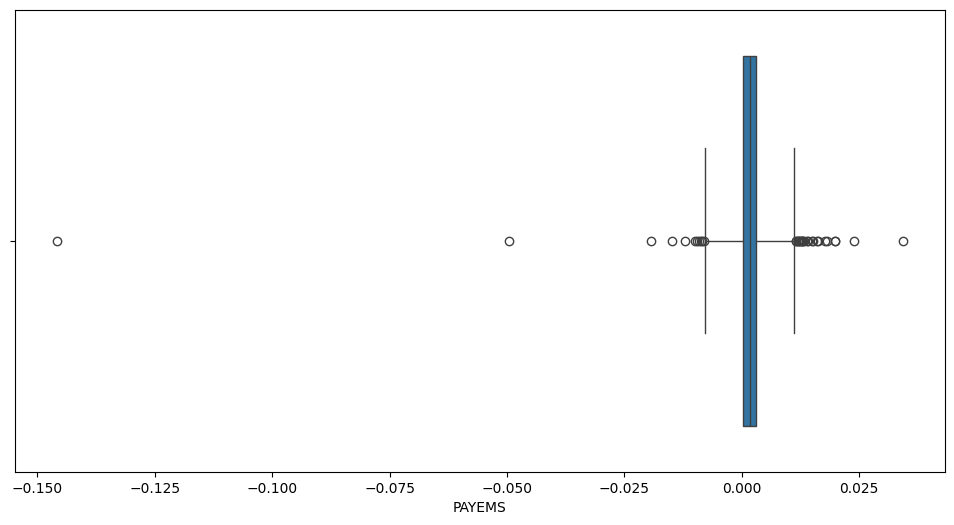

In [61]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(payems, ax=ax, orient='h', whis=3) # whiskers at 3xIQR

**Referenes:**

https://fred.stlouisfed.org/

https://www.stlouisfed.org/research/economists/mccracken/fred-databases

McCracken, M. W., & Ng, S. (2016). FRED-MD: A Monthly Database for Macroeconomic Research. Journal of Business & Economic Statistics, 34(4), 574–589.

McCracken, M.W., Ng, S., 2020. FRED-QD: A Quarterly Database for
Macroeconomic Research, Federal Reserve Bank of St. Louis Working Paper 2020-
005

Katrina Stierholz, 2018, Economic Data Revisions: What They Are and Where to Find Them
https://journals.ala.org/index.php/dttp/article/view/6383/8404